In [1]:
import json
import os
import ast
import csv
import io
from io import StringIO, BytesIO, TextIOWrapper
import gzip
from datetime import datetime, date
from s3_utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import ast
from datetime import timedelta
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score
from xgboost.sklearn import XGBClassifier, XGBRegressor
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import warnings
import sys
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'numpy'

In [2]:
# Define s3 bucket
bucket = 'fouryouandme-study-data'

#List s3 keys
# get_matching_s3_keys(bucket, prefix='bump/') #Remove prefix to view non-BUMP data
bucket = '4youandme-study-data' # for SinC project
bucket = 'fouryouandme-study-data' # for 4YouandMe, Bump, CamCog or Bodyport project

# prefix = {study_name} or {study_name}/{source}
# sources: app_activities, bodyport, camcog, garmin, oura, redcap, rescuetime
# note camcog not accessible to bodyport (and vice a versa)
get_matching_s3_keys(bucket, prefix='bump/oura')
key = 'bump/redcap/wave_4/study_ids.csv.gz'
df_studyID = pandas_from_csv_s3(bucket, key=key, compression='gzip')

# Some dataframes use 'record_id' instead of 'user_id'. 
# You'll need to match it up with df_studyID where'evidation_id' is 'user_id'
# NOTE: Very few examples of this. Birthing data is the important one

# Birthing Data
key = 'bump/redcap/wave_4/birthing_data_cohort_2_only.csv.gz'
df_birth = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_birth['date'] = pd.to_datetime(df_birth.birth_date).dt.date


df_birth = pd.merge(df_birth, df_studyID, on='record_id')
df_birth['user_id'] = df_birth.evidation_id

# There is a missing value in the birthing data. I'm removing it here
df_birth = df_birth.drop(index=50)

# Bodyport Wave 4
key = 'bump/bodyport/wave_4/bodyport.csv.gz'
df_bodyport = pandas_from_csv_s3(bucket, key=key, compression='gzip')
# OPTIONAL: Convert date format
df_bodyport['date'] = pd.to_datetime(df_bodyport.event_date).dt.date 

# Oura Wave 4
key = 'bump/oura/wave_4/oura_sleep.csv.gz'
df_sleep = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sleep['date'] = pd.to_datetime(df_sleep.event_date).dt.date

key = 'bump/oura/wave_4/oura_activity.csv.gz'
df_activity = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_activity['date'] = pd.to_datetime(df_activity.event_date).dt.date

key = 'bump/oura/wave_4/oura_readiness.csv.gz'
df_readiness = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_readiness['date'] = pd.to_datetime(df_readiness.event_date).dt.date

# Surveys Wave 4
key = 'bump/app_activities/wave_4/surveys.csv.gz'
df_survey = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_survey['date'] = pd.to_datetime(df_survey.updated_at).dt.date

key = 'bump/app_activities/wave_4/quick_activities.csv.gz'
df_sam = pandas_from_csv_s3(bucket, key=key, compression='gzip')
df_sam['date'] = pd.to_datetime(df_sam.event_date).dt.date

dfs = [df_sleep, df_bodyport, df_birth, df_activity, df_readiness, df_survey, df_sam]

In [3]:
# get all column names in merged dfs
names = []
for df in dfs:
    [names.append(i) for i in df.columns.to_list()]

In [4]:
bodyport_features = [
    # 'heart_rate',
    # 'breath_average',
    # 'peripheral_fluid',
    # 'total_body_water_percent',
    # 'weight_kg'
]
oura_features = [
    'hr_lowest',
    'hr_average',
    'rmssd',
    'score_deep',
    'temperature_deviation',
    'temperature_trend_deviation',
    'temperature_delta',
    'duration',
    'rem',
    'efficiency',
    'score_alignment',
    'score_rem',
    'light',
    'onset_latency',
    'restless',
    'breath_average',
    'score_disturbances',
    'score',
    'score_efficiency',
    'score_latency',
    'score_total'
]
feature_names = bodyport_features + oura_features
date_list = [
    "d", "id_x", 
    "user_id_x", 
    "identity_id_x", 
    "created_at_x", 
    "updated_at_x", 
    "retrieved_at_x", 
    "subsource_x", 
    "event_date_x",
    "date", "id_y", 
    "user_id_y", 
    "identity_id_y", 
    "created_at_y", 
    "updated_at_y", 
    "retrieved_at_y", 
    "subsource_y", 
    "creation_date", 
    "event_date_y"
]

In [5]:
df_birth[['birth_date', 'date', 'birth_scheduled', 'birth_mode']]

,birth_date,date,birth_scheduled,birth_mode
0,2021-08-16,2021-08-16,3.0,1.0
1,2021-08-28,2021-08-28,2.0,2.0
2,2021-08-11,2021-08-11,1.0,1.0
3,2021-09-22,2021-09-22,3.0,1.0
4,2021-09-11,2021-09-11,2.0,2.0
...,...,...,...,...
144,2022-06-29,2022-06-29,NaN,NaN
145,2022-07-04,2022-07-04,NaN,NaN
146,2022-07-17,2022-07-17,2.0,NaN
147,2022-07-18,2022-07-18,NaN,NaN


In [6]:
len(df_birth.loc[df_birth.birth_scheduled == 2])

69

In [7]:
def get_user(user_id, start=None, end=None):
    user_sleep = df_sleep[df_sleep.user_id == user_id]#.dropna()
    user_bp = df_bodyport[df_bodyport.user_id == user_id]#.dropna()
    
    df2 = pd.merge(user_sleep, user_bp, on="date")

    if "creation_date" in df2.columns:
        for i in range(len(df2)):
            df2["creation_date"][i] = dt.datetime.strptime(df2["creation_date"][i], '%Y-%m-%d %H:%M:%S')
    df2.set_index(df2["date"], inplace=True)
    df2.sort_index(inplace=True)
    
    if start and end:
        mask = (df2['date'] > np.datetime64(start)) & (df2['date'] <= np.datetime64(end))
        # mask = pd.to_datetime(df2["date"]).between(start.astype(str)[0], end.astype(str)[0], inclusive=True)
        df2 = df2[mask]
    return df2

In [8]:
#merge all data features
close_users = []
close_users_id = []
start_close_days = 7
for user_id in tqdm(df_birth[['birth_scheduled', 'birth_date', 'user_id']].dropna().user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id]
    birthdate = birth.reset_index()['date'][0]
    schedule_birth = birth['birth_scheduled'].to_list()[0]
    if len(birth) > 0 and pd.isnull(birthdate) == False and schedule_birth == 2:
        start_close = birthdate - pd.to_timedelta(start_close_days, unit='d') # pd.to_timedelta(100, unit='d')
        date_range = pd.date_range(start_close, birthdate, freq='d')
        df = get_user(user_id, start_close, birthdate)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        if df.isna().sum().max() < round(start_close_days): # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            # df = df.interpolate("linear", 0) #linear interpolation on data
            # df = df.fillna(df.mean(0))
            close_users.append(df)
            close_users_id.append(user_id)
            

100%|██████████| 138/138 [00:02<00:00, 51.40it/s]


In [9]:
further_users = []
further_users_id = []
start_further_days = 14
end_further_days = start_further_days - 7
for user_id in tqdm(df_birth[['birth_scheduled', 'birth_date', 'user_id']].dropna().user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id]
    birthdate = birth.reset_index()['date'][0]
    schedule_birth = birth['birth_scheduled'].to_list()[0]
    if len(birth) > 0 and pd.isnull(birthdate) == False and schedule_birth == 2 and user_id not in close_users_id:
        start_further = birthdate - pd.to_timedelta(start_further_days, unit='d')
        end_further = birthdate - pd.to_timedelta(end_further_days, unit='d')
        date_range = pd.date_range(start_further, end_further, freq='d')
        df = get_user(user_id, start_further, end_further)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        min_date = get_user(user_id).date.dropna().min()
        # while df.isna().sum().max() >= round((start_further_days - end_further_days)) and pd.isnull(min_date) == False and min_date <= start_further:
            
        #     start_further -= pd.to_timedelta(1, unit='d')
        #     end_further -= pd.to_timedelta(1, unit='d')
        #     date_range = pd.date_range(start_further, end_further, freq='d')
        #     df = get_user(user_id, start_further, end_further)
        #     dr = pd.DataFrame()
        #     dr["d"] = date_range.date
        #     dr.set_index(dr.d, inplace=True)
        #     df = dr.join(df)
        #     df = df[feature_names + date_list]
        #     # print(type(min_date), type(start_further))
        if len(df) > 1 and df.isna().sum().max() < round((start_further_days - end_further_days)): # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            # df = df.interpolate("linear", 0) #linear interpolation on data
            # df = df.fillna(df.mean(0))
            further_users.append(df)
            further_users_id.append(user_id)

100%|██████████| 138/138 [00:01<00:00, 81.53it/s]


In [10]:
further_users_b = []
further_users_id_b = []
start_further_days = 14
end_further_days = start_further_days - 7
for user_id in tqdm(df_birth[['birth_scheduled', 'birth_date', 'user_id']].dropna().user_id.unique()):
    birth = df_birth.loc[df_birth.user_id == user_id]
    birthdate = birth.reset_index()['date'][0]
    schedule_birth = birth['birth_scheduled'].to_list()[0]
    if len(birth) > 0 and pd.isnull(birthdate) == False and schedule_birth == 2 and user_id in close_users_id:
        start_further = birthdate - pd.to_timedelta(start_further_days, unit='d')
        end_further = birthdate - pd.to_timedelta(end_further_days, unit='d')
        date_range = pd.date_range(start_further, end_further, freq='d')
        df = get_user(user_id, start_further, end_further)
        dr = pd.DataFrame()
        dr["d"] = date_range.date
        dr.set_index(dr.d, inplace=True)
        df = dr.join(df)
        df = df[feature_names + date_list]
        min_date = get_user(user_id).date.dropna().min()
        # while df.isna().sum().max() >= round((start_further_days - end_further_days)) and pd.isnull(min_date) == False and min_date <= start_further:
            
        #     start_further -= pd.to_timedelta(1, unit='d')
        #     end_further -= pd.to_timedelta(1, unit='d')
        #     date_range = pd.date_range(start_further, end_further, freq='d')
        #     df = get_user(user_id, start_further, end_further)
        #     dr = pd.DataFrame()
        #     dr["d"] = date_range.date
        #     dr.set_index(dr.d, inplace=True)
        #     df = dr.join(df)
        #     df = df[feature_names + date_list]
        #     # print(type(min_date), type(start_further))
        if len(df) > 1 and df.isna().sum().max() < round((start_further_days - end_further_days)): # max null counts in each col is less than 5
            df.set_index(df.d - df.d.min(), inplace=True)
            df = df.resample("D").mean()
            df.set_index(df.index.days, inplace=True)
            # df = df.interpolate("linear", 0) #linear interpolation on data
            # df = df.fillna(df.mean(0))
            further_users_b.append(df)
            further_users_id_b.append(user_id)

100%|██████████| 138/138 [00:02<00:00, 48.63it/s]


In [11]:
print(f'further user group: {len(further_users)}')
print(f'close user group: {len(close_users)}')

further user group: 8
close user group: 37


In [12]:
overlap = len(further_users_id_b) + len(close_users_id) - len(set(further_users_id_b).union(set(close_users_id)))
print(f'common further and close user group: {overlap}')

common further and close user group: 35


In [13]:
len(set(further_users_id).union(set(close_users_id)))

45

In [14]:
set(df_birth.loc[df_birth.birth_scheduled == 2].user_id.to_list()) - set(close_users_id) - set(further_users_id)

{40.0,
 44.0,
 61.0,
 65.0,
 122.0,
 200.0,
 279.0,
 405.0,
 406.0,
 410.0,
 594.0,
 605.0,
 615.0,
 734.0,
 984.0,
 998.0,
 1366.0,
 1368.0,
 1383.0,
 1387.0,
 1436.0,
 1439.0,
 1442.0,
 1659.0}

In [15]:
len(close_users_id)

37

In [162]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
train_percent = 0.8
train_size = int(len(close_users_id) * train_percent)
shuffle_indice_close = shuffle(list(range(len(close_users_id))))
for i in range(train_size):
    # print(close_users_id[shuffle_indice[i]], further_users_id_b[shuffle_indice[i]])
    X_train.append(close_users[shuffle_indice_close[i]][feature_names].to_numpy().flatten())
    y_train.append(0)
for i in range(train_size):
    shuffled_index = shuffle_indice_close[i]
    close_num = close_users_id[shuffled_index]
    if close_num in further_users_id_b:
        further_num = further_users_id_b.index(close_num)
        X_train.append(further_users_b[further_num][feature_names].to_numpy().flatten())
        y_train.append(1)

for i in range(train_size, len(close_users_id)):
    X_val.append(close_users[shuffle_indice_close[i]][feature_names].to_numpy().flatten())
    y_val.append(0)
for i in range(train_size, len(close_users_id)):
    shuffled_index = shuffle_indice_close[i]
    close_num = close_users_id[shuffled_index]
    if close_num in further_users_id_b:
        further_num = further_users_id_b.index(close_num)
        X_val.append(further_users_b[further_num][feature_names].to_numpy().flatten())
        y_val.append(1)

X_train, y_train = shuffle(X_train, y_train)

# shuffle_indice_further = shuffle(list(range(len(further_users_id))))
# train_size = int(len(further_users_id) * 0.8)
# for i in range(train_size):
#     X_train.append(further_users[shuffle_indice_further[i]][feature_names].to_numpy().flatten())
#     y_train.append(1)
# for i in range(train_size, len(further_users)):
#     X_test.append(further_users[i][feature_names].to_numpy().flatten())
#     y_test.append(1)

In [163]:
multi_model_xgr = XGBClassifier()

In [164]:
multi_model_xgr.fit(X_train, y_train)

[05:50:22] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [165]:
predictions = multi_model_xgr.predict(X_val)
print(accuracy_score(predictions, y_val))
print(f1_score(predictions, y_val))
print(y_val)
print(predictions)

0.9333333333333333
0.923076923076923
[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
[0 0 0 0 0 0 0 0 1 1 0 1 1 1 1]


In [132]:
predictions = multi_model_xgr.predict(X_test)
print(accuracy_score(predictions, y_test))
print(f1_score(predictions, y_test))
print(predictions)
print(y_test)

ValueError: ('Expecting 2 dimensional numpy.ndarray, got: ', (0,))

Text(0.5, 0, 'Xgboost Feature Importance')

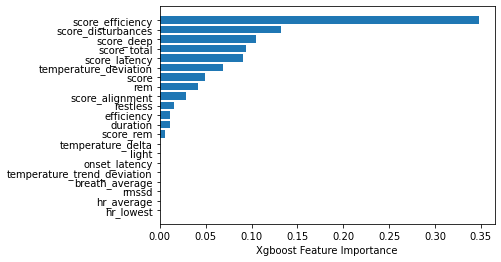

In [40]:
importance_matrix = multi_model_xgr.feature_importances_.reshape(int(multi_model_xgr.feature_importances_.shape[0]/8), 8).sum(axis=1)
sorted_idx = importance_matrix.argsort()
plt.barh(np.array(feature_names)[sorted_idx], importance_matrix[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

In [11]:
import torch
import torch.nn as nn 
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.autograd import Variable
from pathlib import Path
import random
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTMClassifier(nn.Module):
    def __init__(self, feature_size, n_state, hidden_size, rnn="GRU", regres=True, bidirectional=False, return_all=False,
                 seed=random.seed('2021')):
        
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.n_state = n_state
        self.seed = seed
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.rnn_type = rnn
        self.regres = regres
        self.return_all = return_all
        
        # Input to torch LSTM should be of size (seq_len, batch, input_size)
        if self.rnn_type == 'GRU':
            self.rnn = nn.GRU(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)
        else:
            self.rnn = nn.LSTM(feature_size, self.hidden_size, bidirectional=bidirectional, batch_first=True).to(self.device)

        self.regressor = nn.Sequential(nn.BatchNorm1d(num_features=self.hidden_size),
                                       nn.ReLU(),
                                       nn.Dropout(0.3),
                                       nn.Linear(self.hidden_size, self.n_state),
                                       nn.Sigmoid())

    def forward(self, input, past_state=None, **kwargs):
        input = input.to(self.device)
        self.rnn.to(self.device)
        self.regressor.to(self.device)
        if not past_state:
            #  hidden states: (num_layers * num_directions, batch, hidden_size)
            past_state = torch.zeros([1, input.shape[0], self.hidden_size]).to(self.device)
        if self.rnn_type == 'GRU':
            all_encodings, encoding = self.rnn(input, past_state)
        else:
            all_encodings, (encoding, state) = self.rnn(input, (past_state, past_state))
        
        if self.regres:
            if not self.return_all:
                return self.regressor(encoding.view(encoding.shape[1], -1))
            else:
                reshaped_encodings = all_encodings.view(all_encodings.shape[1]*all_encodings.shape[0],-1)
                return torch.t(self.regressor(reshaped_encodings).view(all_encodings.shape[0],-1))
        else:
            return encoding.view(encoding.shape[1], -1)

In [12]:
import copy

def train_model(model, train_dataloader, n_epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    criterion = nn.BCELoss().to(device)

    history = dict(train=[], val=[])

    best_model_wts = copy.deepcopy(model.state_dict())
    iters,iters_sub, train_acc, val_acc = [], [] ,[], []
    
    best_loss = 10000.0
    
    n=0
    for epoch in range(1, n_epochs + 1):
        t0 = time.time()
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch, n_epochs))
        print('Training...')

        total_train_loss = 0
        train_losses=[]
        model = model.train()

        for step, batch in enumerate(train_dataloader):

            if step % 40 == 0 and not step == 0:
                elapsed = (time.time() - t0)
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))
            b_input= batch[0].to(device)
            target =  batch[1].to(device)
            iters.append(n)
            optimizer.zero_grad()
            out = model(b_input)
            out = torch.transpose(out,1,0)[0]

            # target = torch.argmax(b_target, 1)
            loss = criterion(out, target)

            total_train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            train_losses.append(loss.item())
            
            if n % 10 == 0:
                iters_sub.append(n)
                
                #train_acc.append(get_accuracy(model, train_dataloader))
                #print(get_accuracy(model, train_dataloader))
                #val_acc.append(get_accuracy(model, validation_dataloader))
            # increment the iteration number
            n += 1

        training_time = (time.time() - t0)
        avg_train_loss = total_train_loss / len(train_dataloader)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epoch took: {:}".format(training_time))


        print("")
        print("Running Validation...")

        t0 = time.time()
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        val_losses = []
        model = model.eval()

        train_loss = np.mean(train_losses)
    
        history['train'].append(train_loss)
        
        print(f'Epoch {epoch}: train loss {train_loss} ')
    plt.style.use('seaborn-white')
    plt.plot(history['train'])

    plt.title('LSTM  Training Curves')
    plt.ylabel('CE Loss')
    plt.xlabel('Epoch Number')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
    return model.eval(), history

def evaluate_model(model, x_test, y_test):
    #INFERENCE ON TEST SET
    x_test.to(device)
    y_test.to(device)
    predictions = model(x_test).round()
    print(model(x_test))
    print(predictions)
    
    y_test = y_test.numpy()
    y_pred = predictions.detach().numpy()
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    print(f'accuracy: {accuracy}')
    print(f'f1: {f1}')
    print(f'precision: {precision}')

In [13]:
X_train, y_train, X_val, y_val, X_test, y_test = [], [], [], [], [], []
train_percent = 0.8
train_size = int(len(close_users_id) * train_percent)
shuffle_indice_close = shuffle(list(range(len(close_users_id))))
for i in range(train_size):
    # print(close_users_id[shuffle_indice[i]], further_users_id_b[shuffle_indice[i]])
    X_train.append(close_users[shuffle_indice_close[i]][feature_names].to_numpy())
    y_train.append(0)
for i in range(train_size):
    shuffled_index = shuffle_indice_close[i]
    close_num = close_users_id[shuffled_index]
    if close_num in further_users_id_b:
        further_num = further_users_id_b.index(close_num)
        X_train.append(further_users_b[further_num][feature_names].to_numpy())
        y_train.append(1)

for i in range(train_size, len(close_users_id)):
    X_val.append(close_users[shuffle_indice_close[i]][feature_names].to_numpy())
    y_val.append(0)
for i in range(train_size, len(close_users_id)):
    shuffled_index = shuffle_indice_close[i]
    close_num = close_users_id[shuffled_index]
    if close_num in further_users_id_b:
        further_num = further_users_id_b.index(close_num)
        X_val.append(further_users_b[further_num][feature_names].to_numpy())
        y_val.append(1)

X_train, y_train = shuffle(X_train, y_train)

# shuffle_indice_further = shuffle(list(range(len(further_users_id))))
# train_size = int(len(further_users_id) * 0.1)
# for i in range(train_size):
#     X_train.append(further_users[shuffle_indice_further[i]][feature_names].to_numpy().flatten())
#     y_train.append(1)
for i in range(len(further_users)):
    X_test.append(further_users[i][feature_names].to_numpy())
    y_test.append(1)

ion...
Epoch 393: train loss 0.5184659063816071 

======== Epoch 394 / 500 ========
Training...

  Average training loss: 0.53
  Training epoch took: 0.08895754814147949

Running Validation...
Epoch 394: train loss 0.5297672549883524 

======== Epoch 395 / 500 ========
Training...

  Average training loss: 0.50
  Training epoch took: 0.013319015502929688

Running Validation...
Epoch 395: train loss 0.5017569065093994 

======== Epoch 396 / 500 ========
Training...

  Average training loss: 0.51
  Training epoch took: 0.09290313720703125

Running Validation...
Epoch 396: train loss 0.5140732228755951 

======== Epoch 397 / 500 ========
Training...

  Average training loss: 0.50
  Training epoch took: 0.09477734565734863

Running Validation...
Epoch 397: train loss 0.5049384832382202 

======== Epoch 398 / 500 ========
Training...

  Average training loss: 0.47
  Training epoch took: 0.09572267532348633

Running Validation...
Epoch 398: train loss 0.46769662698109943 

======== Epoch 399

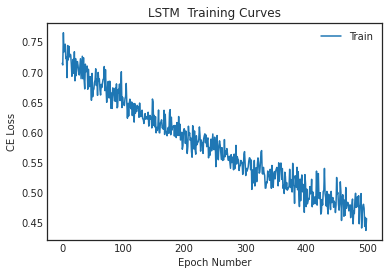

In [15]:
import time
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.nan_to_num(X_train) # replace all missing data with 0
X_val = np.nan_to_num(X_val) # replace all missing data with 0
X_test = np.nan_to_num(X_test) # replace all missing data with 0

X_train = torch.flip(torch.tensor(X_train, dtype=torch.float), [1,2])
y_train = torch.tensor(y_train, dtype=torch.float)
X_val = torch.flip(torch.tensor(X_val, dtype=torch.float), [1,2])
y_val = torch.tensor(y_val, dtype=torch.float)
X_test = torch.flip(torch.tensor(X_test, dtype=torch.float), [1,2])
y_test = torch.tensor(y_test, dtype=torch.float)

train_dataset= TensorDataset(X_train, y_train)
val_dataset= TensorDataset(X_val, y_val)
test_dataset= TensorDataset(X_test, y_test)

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 20

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size
        )
val_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset)
        )
test_dataloader = DataLoader(
            test_dataset, 
            sampler = SequentialSampler(test_dataset)
        )
model = LSTMClassifier(X_train.shape[2], #num features 
                1, #num classes,
                10, #hidden size
                rnn="LSTM" #rnn type
           )
model.to(device)
model, history = train_model(model, train_dataloader,500, 1e-4)

In [16]:
evaluate_model(model, X_val, y_val)

tensor([[0.6649],
        [0.2926],
        [0.2832],
        [0.6280],
        [0.2083],
        [0.3346],
        [0.1487],
        [0.2738],
        [0.6366],
        [0.3062],
        [0.6280],
        [0.8956],
        [0.6407],
        [0.6496],
        [0.6280]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<RoundBackward0>)
accuracy: 0.8
f1: 0.7999999999999999
precision: 0.75


In [188]:
evaluate_model(model, X_test, y_test)

tensor([[0.6532],
        [0.7073],
        [0.6532],
        [0.3436],
        [0.3809],
        [0.3439],
        [0.3945],
        [0.3928]], grad_fn=<SigmoidBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<RoundBackward0>)
accuracy: 0.375
f1: 0.5454545454545454
precision: 1.0


In [30]:
from sklearn.model_selection import cross_val_score, ShuffleSplit, KFold
cv = ShuffleSplit(n_splits=5, train_size=0.8, test_size=0.2, random_state=3)
scores = cross_val_score(multi_model_xgr, X, y, cv=cv, scoring='f1')
print(scores)

[03:01:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:01:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [66]:
print(scores.sum()/len(scores))

0.8735264735264735


In [47]:
len(y_b)

37

In [27]:
kf = KFold(n_splits=5, shuffle=True, random_state=20)
for train, test in kf.split(X):
    X_train, X_test, y_train, y_test = X[train], X[test], y[train], y[test]
    multi_model_xgr = XGBClassifier(random_state=0)
    multi_model_xgr.fit(X_train, y_train)
    predictions = multi_model_xgr.predict(X_test)
    predictions_b = multi_model_xgr.predict(X_b)
    print(predictions)
    print(predictions_b)
    accuracy_xgb = accuracy_score(predictions, y_test)
    f1_xgb = f1_score(predictions, y_test)
    accuracy_xgb_b = accuracy_score(predictions_b, y_b)
    f1_xgb_b = f1_score(predictions_b, y_b)
    print(f'accuracy: {accuracy_xgb}, {accuracy_xgb_b}')
    print(f'f1 score: {f1_xgb}, {f1_xgb_b}')
    print('--------------------------------')
    # importance_matrix = multi_model_xgr.feature_importances_.reshape(int(multi_model_xgr.feature_importances_.shape[0]/8), 8).sum(axis=1)
    # sorted_idx = importance_matrix.argsort()
    # plt.barh(np.array(feature_names)[sorted_idx], importance_matrix[sorted_idx])
    # plt.xlabel(f"Xgboost Feature Importance, accuracy: {accuracy_xgb}, f1 score: {f1_xgb} ")
    # plt.show()

[03:39:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1 0 1 0 0 0 1 0 1 0 1 1 0 1 0]
[0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accuracy: 0.6666666666666666, 0.918918918918919
f1 score: 0.6666666666666666, 0.9577464788732395
--------------------------------
[03:39:46] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[1 1 1 1 1 1 0 1 0 0 0 1 1 0 0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accuracy: 0.8, 1.0
f1 score: 0.8, 1.0
--------------------------------
[03:39:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the defa

In [1]:
# Plot metric over time
# Includes vertical yellow line if birthing data exists
#     Blue horizontal line is mean before birth
#     Red horizontal line is mean after birth
def exploreDataBirthBA(df, col, user_id):
    plt.rcParams.update({'figure.max_open_warning': 0})
    sns.set_theme(style='darkgrid')
    pdf = df.loc[df.user_id == user_id]

    
    plt.figure(figsize=(12,4))
    sns.scatterplot(data=pdf, x='date', y=col, ci=None, color='purple')
    sns.lineplot(data=pdf, x='date', y=col, ci=None)

    # Plot birthing data if it exists for that user
    if (len(df_birth.loc[df_birth.user_id == user_id]) != 0):
        birth = df_birth.loc[df_birth.user_id == user_id].reset_index()
        plt.axvline(x=birth.date, color = 'y', ls='--')
        ymin, ymax = plt.gca().get_ylim()
        xmin, xmax = plt.gca().get_xlim()
        plt.text(birth.date, ymax, birth['date'][0], fontsize=12, color='y')
        
        # Dataframe of data before birth
        after = pdf[~(pdf['date'] < birth.date[0])]
        before = pdf[~(pdf['date'] > birth.date[0])]
        before_avg = before[col].mean()
        after_avg = after[col].mean()
#         print('Pre-birth Average: ', before_avg)
#         print('Post-birth Average: ', after_avg)
        plt.hlines(y=before_avg, xmin=xmin, xmax=birth.date, color='blue', linestyles='dashdot')
        plt.hlines(y=after_avg, xmin=birth.date, xmax=xmax, color='red', linestyles='dashdot')
#         sns.lineplot(data=before, x='date', y=col, ci=None, color='r')
#         sns.lineplot(data=after, x='date', y=col, ci=None, color='r')

    plt.xlabel(''); plt.ylabel(col)
    plt.title('User ID: ' + str(user_id))
    plt.show()
exploreDataBirthBA(df_sleep, 'score_alignment', 136)

NameError: name 'df_sleep' is not defined

In [123]:
df_readiness.columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'period_id',
       'rest_mode_state', 'score', 'score_activity_balance',
       'score_hrv_balance', 'score_previous_day', 'score_previous_night',
       'score_recovery_index', 'score_resting_hr', 'score_sleep_balance',
       'score_temperature', 'date'],
      dtype='object')

In [124]:
df_sleep.columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'awake', 'bedtime_end',
       'bedtime_end_delta', 'bedtime_start', 'bedtime_start_delta',
       'breath_average', 'deep', 'duration', 'efficiency', 'hr_5min',
       'hr_average', 'hr_lowest', 'hypnogram_5min', 'is_longest', 'light',
       'midpoint_at_delta', 'midpoint_time', 'onset_latency', 'period_id',
       'rem', 'restless', 'rmssd', 'rmssd_5min', 'score', 'score_alignment',
       'score_deep', 'score_disturbances', 'score_efficiency', 'score_latency',
       'score_rem', 'score_total', 'temperature_delta',
       'temperature_deviation', 'temperature_trend_deviation', 'timezone',
       'total', 'date'],
      dtype='object')

In [125]:
df_activity.columns

Index(['id', 'user_id', 'identity_id', 'created_at', 'updated_at',
       'retrieved_at', 'subsource', 'event_date', 'average_met', 'cal_active',
       'cal_total', 'class_5min', 'daily_movement', 'day_end', 'day_start',
       'high', 'inactive', 'inactivity_alerts', 'low', 'medium', 'met_1min',
       'met_min_high', 'met_min_inactive', 'met_min_low', 'met_min_medium',
       'non_wear', 'rest', 'rest_mode_state', 'score',
       'score_meet_daily_targets', 'score_move_every_hour',
       'score_recovery_time', 'score_stay_active', 'score_training_frequency',
       'score_training_volume', 'steps', 'target_calories', 'target_km',
       'target_miles', 'timezone', 'to_target_km', 'to_target_miles', 'total',
       'date'],
      dtype='object')